In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torchdiffeq import odeint

Function definition for the Van der Pol Oscillator.

In [35]:
y = torch.zeros(2)
y[1] = 1.

u = torch.zeros(1)

mu = 1
f = lambda y, u: torch.stack((y[...,1], mu * (1 - y[...,0]**2) * y[...,1] - y[...,0] + u[...,0]))
f(y,u)

tensor([1., 1.])

Solving using 4th order Runge-Kutta.

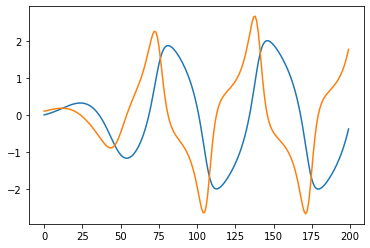

In [4]:
y0 = torch.zeros(2)
y0[1] = .1
u = torch.zeros(1)
dt = 0.1
N = 200
Y = odeint(lambda t, y: f(y,u), y0, torch.Tensor([i * dt for i in range(N)]), method='rk4')

plt.plot(Y[:,0].detach().numpy())
plt.plot(Y[:,1].detach().numpy())
plt.show()

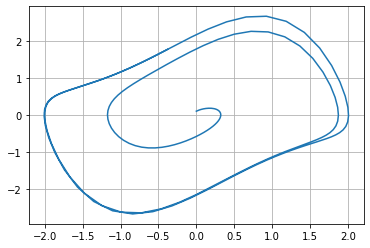

In [5]:
plt.plot(Y[:,0].detach().numpy(), Y[:,1].detach().numpy())
plt.grid()
plt.show()

For our experiments, $u \in [−1, 1]$ and $y1, y2 \in [−3, 3]$.

# Data

In [20]:
T = 0.5  # sampling time

In [19]:
X_t

tensor([[0.0000, 2.8540, 0.7521, 0.1622],
        [0.0000, 2.5011, 0.3235, 0.4454],
        [0.0000, 1.1154, 0.2513, 0.8588],
        ...,
        [0.0000, 1.6838, 1.0348, 0.5792],
        [0.0000, 1.8137, 2.6929, 0.7292],
        [0.0000, 1.8049, 1.7431, 0.6826]])

In [21]:
# TODO: I should generate the data points during training, rather than fixing them beforehand
N_t = 1000
Y_t = torch.rand(N_t,2) * 3  # State data points for training
U_t = torch.rand(N_t,1) * 1  # Input data points for training
X_t = torch.cat((torch.zeros(N_t,1),Y_t,U_t), dim=1)

N_f = 100000
Y_f = torch.rand(N_f,2) * 3  # State data points for training
U_f = torch.rand(N_f,1) * 1  # Input data points for training
T_f = torch.rand(N_f,1) * T  # Time data points for training
X_f = torch.cat((torch.zeros(N_f,1),Y_f,U_f), dim=1)
delY_f = f(Y_f,U_f).T

In [69]:
net = torch.nn.Sequential(
    nn.Linear(4,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,2),
    nn.Tanh()
)
h = lambda y: y * 3  # maps tanh output to state domain

# TODO: how to compute derivatives for the whole batch efficiently?
x = X_f[0]
x.requires_grad_()
y_pred = h(net(x))
torch.autograd.grad(y_pred[0], x, retain_graph=True, create_graph=True)[0]

tensor([ 7.8067e-05, -1.3895e-02, -4.1177e-04,  1.4231e-02],
       grad_fn=<SqueezeBackward1>)

In [72]:
net = torch.nn.Sequential(
    nn.Linear(4,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,20),
    nn.Tanh(),
    nn.Linear(20,2),
    nn.Tanh()
)
h = lambda y: y * 3  # maps tanh output to state domain

x = X_f[:1]
x.requires_grad_()
y_pred = h(net(x))
print(torch.autograd.grad(y_pred[:,0], x, retain_graph=True, create_graph=True)[0])
x = X_f[:5]
x.requires_grad_()
y_pred = h(net(x))
# why does this work? based on https://discuss.pytorch.org/t/gradient-of-scalar-output-w-r-t-input-in-batches/129043
torch.autograd.grad(y_pred[:,0], x, grad_outputs=torch.ones_like(y_pred[:,0]), retain_graph=True, create_graph=True)[0]

tensor([[-0.0489, -0.1036,  0.0099,  0.0229]], grad_fn=<MmBackward0>)


tensor([[-0.0489, -0.1036,  0.0099,  0.0229],
        [-0.0341, -0.1592,  0.0511,  0.0506],
        [-0.0600, -0.1345,  0.0396, -0.0025],
        [-0.0190, -0.1594,  0.0247,  0.0713],
        [-0.0252, -0.1648,  0.0356,  0.0642]], grad_fn=<MmBackward0>)